# 1. Introduction

In this project, we will build a convolutional neural network step by step. In this notebook, we will implement all the functions required to build a convolutional neural network. We will then train the model, which mainly consists of two parts: convolution layer and pooling layer.

# 2. Packages

* numpy : The fundamental package for scientific computing with Python.
* matplotlib : A comprehensive library for creating static, animated, and interactive visualizations in Python.
* math : Python has a built-in module that we can use for mathematical tasks.
* pandas.read_csv : Provides functionality for reading a csv dataset from a GitHub repository.
* sklearn.model_selection.train_test_split: A function that helps us to split train and test data.
* os: A module provides the facility to establish the interaction between the user and the operating system. We can access the image directory by os.
* cv2.imread: It is the module import name for opencv-python.
* time: Provides various time-related functions.
* google.colab.drive: Let's us connect colab and our google drive.
* sys: Let's us access system-specific parameters and functions.

⚠️ **NOTICE** ⚠️:
*   np.random.seed(seed) is used to keep all the random function calls consistent.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import sys
sys.path.append("/content/drive/MyDrive/Functions") ## the path of the directory where we place dense.py, activation.py ....

In [3]:
import os
import math
import time 
import numpy as np
from cv2 import imread, IMREAD_GRAYSCALE # IMREAD_GRAYSCALE allow us to load the image as gray scale image
from pandas import read_csv
import matplotlib.pyplot as plt

from Dense import Dense
from Activation import Activation
from Loss import compute_BCE_cost
from Predict import predict

output = {}
seed = 1
np.random.seed(seed)

# 3. Convolution layer

In this section, we will need to implement a very important part of the convolutional neural network, which is the convolution layer. Convolution layer enables us to capture the important features of input images.

In [4]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C), where m represent the number of examples.
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), "constant", constant_values = (0,0))
    
    return X_pad

In [5]:
class Conv():
    def __init__(self, filter_size=2, input_channel=3, output_channel=8, pad=1, stride=1, seed=1):
        
        self.filter_size= filter_size
        self.input_channel=input_channel
        self.output_channel=output_channel
        self.seed = seed
        
        self.parameters = {"pad": pad, "stride": stride}
        self.initialize_parameters()
        
        
        self.name="conv"

    def initialize_parameters(self):
        """
        Argument:
        self.filter_size -- size of the filter
        self.input_channel -- size of the input channel
        self.output_channel -- size of the output channel
        self.parameters -- python dictionary containing your parameters:
                           W -- weight matrix of shape (filter_size, filter_size, input channel size, output channel size)
                           b -- bias vector of shape (1, 1, 1, output channel size)
                           pad -- amount of padding around each image on vertical and horizontal dimensions
                           stride -- represent the amount of movement that a filter move in one step
        """
        np.random.seed(seed)

        limit = math.sqrt(6 / (self.input_channel + self.output_channel))
        W = np.random.uniform(-limit, limit, (self.filter_size,self.filter_size,self.input_channel,self.output_channel))
        b = np.zeros((1,1,1,self.output_channel))

        assert(W.shape == (self.filter_size,self.filter_size,self.input_channel,self.output_channel))
        assert(b.shape == (1,1,1,self.output_channel))

        self.parameters['W'] = W
        self.parameters['b'] = b
        
    
    
    def conv_single_step(self, a_slice_prev, W, b):
        """
        Apply a filter W on a_slice_prev.

        Arguments:
        a_slice_prev -- slice of input data of shape (filter_size, filter_size, n_C_prev)
        W -- Weight parameters contained in a window - matrix of shape (filter_size, filter_size, n_C_prev)
        b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)

        Returns:
        Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
        """

        # Element-wise product between a_slice and W.
        s = np.multiply(a_slice_prev, W)
        # Sum over all entries of the volume s.
        Z = np.sum(s)
        # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
        Z = Z + float(b)

        return Z
    
    def forward(self, A_prev):
        """
        Implements the forward propagation for a convolution layer

        Arguments:
        A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)

        Returns:
        Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
        """

        # Retrieve dimensions from A_prev's shape
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

        # Retrieve dimensions from W's shape
        (f, f, n_C_prev, n_C) = self.parameters["W"].shape


        # Compute the dimensions of the convolution output volume using the formula given below.
        n_H = int((n_H_prev - f + (2 * self.parameters["pad"])) / self.parameters["stride"]) + 1
        n_W = int((n_W_prev - f + (2 * self.parameters["pad"])) / self.parameters["stride"]) + 1

        # Initialize the output volume Z with zeros.
        Z = np.zeros((m, n_H, n_W, n_C))

        # if pad!=0, create A_prev_pad by padding A_prev with the parameter "pad".
        A_prev_pad = zero_pad(A_prev, self.parameters["pad"])

        for i in range(m):                                 # loop over the batch of training examples
            a_prev_pad = A_prev_pad[i,:,:,:]               # Select ith training example's padded activation
            for h in range(n_H):                           # loop over vertical axis of the output volume
                for w in range(n_W):                       # loop over horizontal axis of the output volume
                    for c in range(n_C):                   # loop over channels (= #filter) of the output volume

                        # Find the corners of the current "slice"
                        v_start = h*self.parameters["stride"]
                        v_end = v_start + f
                        h_start = w*self.parameters["stride"]
                        h_end = h_start + f

                        # Use the corners to define the slice of a_prev_pad.
                        a_slice_prev = a_prev_pad[v_start:v_end, h_start:h_end, :]

                        # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron.
                        Z[i, h, w, c] = self.conv_single_step(a_slice_prev, self.parameters["W"][:,:,:,c], self.parameters["b"][:,:,:,c])

        # Making sure our output shape is correct
        assert(Z.shape == (m, n_H, n_W, n_C))

        # Save information in "cache" for the backward pass
        self.cache = A_prev

        return Z
    
    def backward(self, dZ):
        """
        Implement the backward propagation for a convolution layer

        Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)

        Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                   numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        """


        A_prev = self.cache

        # Retrieve dimensions from A_prev's shape
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

        # Retrieve dimensions from W's shape
        (f, f, n_C_prev, n_C) = self.parameters["W"].shape


        # Retrieve dimensions from dZ's shape
        (m, n_H, n_W, n_C) = dZ.shape

        # Initialize dA_prev, dW, db with the correct shapes
        dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
        dW = np.zeros((f, f, n_C_prev, n_C))
        db = np.zeros((1, 1, 1, n_C))

        # Pad A_prev and dA_prev
        A_prev_pad = zero_pad(A_prev, self.parameters["pad"])
        dA_prev_pad = zero_pad(dA_prev, self.parameters["pad"])

        for i in range(m):                       # loop over the training examples

            # select ith training example from A_prev_pad and dA_prev_pad
            a_prev_pad = A_prev_pad[i]
            da_prev_pad = dA_prev_pad[i]

            for h in range(n_H):                   # loop over vertical axis of the output volume
                for w in range(n_W):               # loop over horizontal axis of the output volume
                    for c in range(n_C):           # loop over the channels of the output volume

                        # Find the corners of the current "slice"
                        vert_start = h * self.parameters["stride"]
                        vert_end = vert_start + f
                        horiz_start = w * self.parameters["stride"]
                        horiz_end = horiz_start + f

                        # Use the corners to define the slice from a_prev_pad
                        a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                        # Update gradients for the window and the filter's parameters
                        da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += self.parameters["W"][:,:,:,c] * dZ[i, h, w, c]
                        dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                        db[:,:,:,c] += dZ[i, h, w, c]

            # Set the ith training example's dA_prev to the unpaded da_prev_pad
            dA_prev[i, :, :, :] = da_prev_pad[self.parameters["pad"]:da_prev_pad.shape[0]-self.parameters["pad"], 
                                              self.parameters["pad"]:da_prev_pad.shape[1]-self.parameters["pad"], :]

        assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

        self.dW = dW
        self.db = db

        return dA_prev
    
    def update(self, learning_rate):
        """
        Update parameters using gradient descent
        
        Arguments:
        learning rate -- step size
        """

        self.parameters["W"] = self.parameters["W"] - learning_rate * self.dW
        self.parameters["b"] = self.parameters["b"] - learning_rate * self.db

## 3.1 initialization
Using Glorot uniform initialization to initialize the convolution layer's filters with the parameters: filter_size, input_channel, and output_channel.

*   Use random initialization (uniform distribution) for the weight matrices. Draws samples from a uniform distribution within [-limit, limit], where limit = sqrt(6 / (fan_in + fan_out)), fan_in is the **number of input channel** and fan_out is the **number of output channel**. However, in the usual implementation, we will consider fan_in and fan_out as the number of input units and the number of output units.
*   Use zero initialization for the biases.

It will take following parameters to initialize the convolution layer:
*   filter_size: The filter will be in the shape of (filter_size*filter_size)
*   input_channel: size of the input channel
*   output_channel: size of the output channel
*   pad: amount of padding around each image on vertical and horizontal dimensions
*   stride: represent the amount of movement that a filter move in one step

## 3.2  Zero-Padding

Pad around each image on vertical and horizontal dimensions with zero.

1. It allows us to use a convolution layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks since otherwise the height/width would shrink as we go to deeper layers. 
2. It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

This function takes the following inputs:
*   X: input.
*   pad: amount of padding around each image on vertical and horizontal dimensions.

## 3.3 Convolution_single_step
In this part, we will implement a single step of convolution, in which we apply the filter to a single position of the input. This will be used to build a convolutional unit.

We will convolve an f*f filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias.

This function takes the following inputs:
*   a_slice_prev: the output of the activation by the previous layer.
*   W: the filter with size f*f.
*   b: the bias.


## 3.4 Forward pass
In the forward pass, we will take many filters and convolve them through the input. Each 'convolution' gives us a 2D matrix output. We will then stack these outputs to get a 3D volume.

Notice that the output shape of the convolution forward will be (H, W, C).
* $H= \lfloor\frac{H_{prev }-f+2*pad}{stride}\rfloor+1$
* $W= \lfloor\frac{W_{prev }-f+2*pad}{stride}\rfloor+1$
* $C = $ number of filters

f = filter_size

This function takes the following input:
*   A_prev: the output of the activation by the previous layer, it's an array with shape (m, H_prev, W_prev, C_prev).
    *  m: number of examples.
    *  H_prev, W_prev, C_prev: the height, width, and channel of the output of the previous layer.

Here are some steps for us to finish in this part:
1. Define **a_slice_prev**, which represent the input slice of conv_single_step( ).
2. To define **a_slice_prev**, we have to define its' corners: **vert_start, vert_end, horiz_start and horiz_end**.

## 3.5 Update parameters
In this section we will update the parameters of the convolution layer, using gradient descent:

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

**Instructions**: 
*   Update parameters using gradient descent on $W^{[l]}$ and $b^{[l]}$.


# 4. Maxpooling layer

The pooling layer reduces the size (height and width) of the input. It helps reduce computation, as well as helps make feature detectors more invariant to their position in the input. In this section, we will focus on maxpooling layer.

In [11]:
class MaxPool():
    def __init__(self, filter_size=2, stride=2):
        """
        Argument:
        self.parameters -- python dictionary containing your parameters:
                           f -- size of a filter
                           stride -- the amount of movement that a filter move in one step
        """
    
        self.parameters = {"f": filter_size, "stride": stride}
        self.name="maxpool"
        
        
    def forward(self, A_prev):
        """
        Implements the forward pass of the max pooling layer

        Arguments:
        A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)

        Returns:
        A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
        """

        # Retrieve dimensions from the input shape.
        (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape


        # Define the dimensions of the output.
        n_H = int((n_H_prev - self.parameters["f"]) / self.parameters["stride"]) + 1
        n_W = int((n_W_prev - self.parameters["f"]) / self.parameters["stride"]) + 1
        n_C = n_C_prev

        # Initialize output matrix A with zeros.
        A = np.zeros((m, n_H, n_W, n_C))

        for i in range(m):                           # loop over the training examples
            for h in range(n_H):                     # loop on the vertical axis of the output volume
                for w in range(n_W):                 # loop on the horizontal axis of the output volume
                    for c in range (n_C):            # loop over the channels of the output volume

                        # Find the corners of the current "slice".
                        v_start = self.parameters["stride"] * h
                        v_end = v_start + self.parameters["f"]
                        h_start = self.parameters["stride"] * w
                        h_end = h_start + self.parameters["f"]

                        # Use the corners to define the current slice on the ith training example of A_prev, channel c.
                        a_prev_slice = A_prev[i, v_start:v_end, h_start:h_end, c]

                        # Compute the max pooling operation on a_prev_slice.
                        A[i, h, w, c] = np.max(a_prev_slice)

        # Store the input in "cache" for backward pass
        self.cache = A_prev

        # Making sure your output shape is correct
        assert(A.shape == (m, n_H, n_W, n_C))

        return A
    
    def create_mask_from_window(self, x):
        """
        Creates a mask from an input x to identify the max entry of x.

        Arguments:
        x -- Array of shape (filter_size, filter_size)

        Returns:
        mask -- Array of the same shape as filter, contains a True at the position corresponding to the max entry of x.
        """

        mask = x == np.max(x)

        return mask
    
    def backward(self, dA):
        """
        Implements the backward pass of the max pooling layer

        Arguments:
        dA -- gradient of cost with respect to the output of the pooling layer, same shape as A 

        Returns:
        dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
        """

        # Retrieve information from cache
        A_prev = self.cache

        # Retrieve dimensions from A_prev's shape and dA's shape
        m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
        m, n_H, n_W, n_C = dA.shape

        # Initialize dA_prev with zeros
        dA_prev = np.zeros(A_prev.shape)

        for i in range(m):  # loop over the training examples
            # select training example from A_prev                    
            a_prev = A_prev[i]
            for h in range(n_H):   # loop on the vertical axis            
                for w in range(n_W):  # loop on the horizontal axis             
                    for c in range(n_C): # loop over the channels

                        # Find the corners of the current "slice"          
                        vert_start = h * self.parameters["stride"]
                        vert_end = vert_start + self.parameters["f"]
                        horiz_start = w * self.parameters["stride"]
                        horiz_end = horiz_start + self.parameters["f"] 

                        #Use the corners and "c" to define the current slice from a_prev
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # Create the mask from a_prev_slice
                        mask = self.create_mask_from_window(a_prev_slice)
                        # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dA)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])



        # Make sure your output shape is correct
        assert(dA_prev.shape == A_prev.shape)

        return dA_prev



## 4.1 Forward pass

It will take following parameters to initialize a max pooling layer:
*   filter_size: the filter will be in the shape of (filter_size*filter_size)
*   stride: the amount of movement that a filter move in one step

In the forward pass, we will slide a ( f*f ) filter over the input and store the max value of the window in the output. (f means the filter size)

Notice that the output shape of the forward pass will be (H, W, C).
* $H= \lfloor\frac{H_{prev }-f}{stride}\rfloor+1$
* $W= \lfloor\frac{W_{prev }-f}{stride}\rfloor+1$
* $C = C_{prev}$

This forward function takes the following input:
*   A_prev: the output of the previous layer, it's an array with shape (m, H_prev, W_prev, C_prev).






# 5. Flatten layer

To connect the convolution layer and the dense layer, we should flatten the output of the convolution layer or max pooling layer before dense layer.

In [13]:
class Flatten():
    def __init__(self):
        self.name="flatten"

    def forward(self, A_prev):
        """
        Implements the forward pass of the flatten layer

        Arguments:
        A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)

        Returns:
        A -- output of the flatten layer, a 1-dimensional array
        """

        # Save information in "cache" for the backward pass
        self.cache = A_prev[0].shape

        A = A_prev.reshape((A_prev.shape[0], A_prev.shape[1]*A_prev.shape[2]*A_prev.shape[3]))

        return A

    def backward(self, dA):
        """
        Implements the backward pass of the flatten layer

        Arguments:
        dA -- Input data, a 1-dimensional array

        Returns:
        dA_prev -- An array with its original shape (the output shape of its' previous layer).
        """
        
        dA_prev = dA.reshape((dA.shape[0], self.cache[0], self.cache[1], self.cache[2]))
        
        return dA_prev

## 5.1 Forward pass

Implement the forward pass of flatten layer. Turn the input array into a 1-dimensional array.

This function takes the following input:
*   A_prev: Input data, it's an array with shape (m, n_H_prev, n_W_prev, n_C_prev).


## 5.2  Backward pass

Implement the backward pass of flatten layer. Turn the input array back to its original shape.(the output shape of its' previous layer).

This function takes the following input:
*   dA: the output of backward pass from the next layer, it's a 1-dimensional array.

# 6. Model
Alright, now we have all the tools that are needed to build a convolutional neural network. Let's get started!

1. In this part, we will call model.add( ) to add a layer into the model. For example:
* model.add(Conv( )): add a convolution layer into the model.
* model.add(Dense( )): add a dense layer into the model.
* model.add(Activation( )): add an activation layer into the model.

2. Because the dense layer we implemented takes the input shape as [:, m], where m represents the number of examples. However, when the training data go through the convolution layer and maxpool layer, its shape will be [m,:]. As a consequence, in the forward pass, the output of flatten.forward( ) need to be transposed. Similarly, in the backward pass, before the data goes into flatten.backward( ), it needs to be transposed again.


In [16]:
class Model():
    def __init__(self):       
        self.layers=[]

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        A = X
        for l in range(len(self.layers)):
            if(self.layers[l].name=="flatten"):
                A=self.layers[l].forward(A).T # Transpose after flatten layer
            else:
                A=self.layers[l].forward(A)
        return A

    def backward(self, AL=None, Y=None):
        L = len(self.layers)

        if self.layers[-1].name == "sigmoid":
            E = 1e-5
            dAL = - (np.divide(Y, AL + E) - np.divide(1 - Y, 1 - AL + E))
            dZ = self.layers[-1].backward(dA=dAL)  #activation layer backward
            dA_prev = self.layers[-2].backward(dZ) #linear layer backward
        else:
            dZ = self.layers[-1].backward(Y=Y)
            dA_prev = self.layers[-2].backward(dZ)

        
        # Loop from l=L-3 to l=0
        for l in reversed(range(L-2)):
            if(self.layers[l].name=="flatten"):
                dA_prev=self.layers[l].backward(dA_prev.T) # Transpose before goes into flatten layer
            else:
                dA_prev=self.layers[l].backward(dA_prev)

        return dA_prev

    def update(self, learning_rate):
        """
        Arguments:
        learning_rate -- step size
        """
        
        # Only convolution layer and dense layer have to update parameters
        for l in range(len(self.layers)):
            if self.layers[l].name == "conv" or self.layers[l].name == "dense":
                self.layers[l].update(learning_rate)       

# 7. Binary classification

Now we have all the tools we need to get started with classification. In this section, we will build a binary classifier using the functions we have previously written. We will create a model that can determine whether a CXR image is normal or not. There will be 600 training images and 60 testing images, and the size of all images are 32 * 32 * 1.

**Instruction**:
*   Preprocess the data by using min-max scaling to normalize X. Normalize the values of each feature between 0 and 1.
*   Use batch gradient descent to train the model.



In [ ]:
!unzip Training_data.zip
!unzip Testing_data.zip

## 7.1 Data preprocessing

In [19]:
PATH = "Training_data"  #path to our training image
file_dir = os.listdir(PATH) #read the images from the directory
file_dir.sort() #Make sure the images are loaded in order
X_train = np.array([])

# Prepare X_train
# The shape of X_train will be (number of examples, height of image, width of image, channel of image)
# Use imread(PATH, IMREAD_GRAYSCALE) to load image

# Load data
l = []
for filename in file_dir:
  PATH = "Training_data" + "/" + filename
  img = imread(PATH, IMREAD_GRAYSCALE)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  l.append(img)
X_train = np.array(l)
print("Shape of X_train:", X_train.shape)

# Normalize data
X = X_train
min_X, max_X = X.min(axis = 0), X.max(axis = 0)
X_train = (X - min_X) / (max_X - min_X)

Shape of X_train: (600, 32, 32, 1)


In [20]:
PATH = "Testing_data"  #path to our testing image
file_dir = os.listdir(PATH)
file_dir.sort()
X_test = np.array([])

# Prepare X_test
# The shape of X_teset will be (number of examples, height of image, width of image, channel of image)

# Load data
l = []
for filename in file_dir:
  if filename == ".ipynb_checkpoints":
    continue
  PATH = "Testing_data" + "/" + filename
  img = imread(PATH, IMREAD_GRAYSCALE)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  l.append(img)
X_test = np.array(l)
print("Shape of X_test:", X_test.shape)

# Normalize data
X = X_test
min_X, max_X = X.min(axis = 0), X.max(axis = 0)
X_test = (X - min_X) / (max_X - min_X)

Shape of X_test: (60, 32, 32, 1)


In [21]:
data = read_csv("Training_label.csv")

y_train = []

# Prepare y_train
# The shape of y_train will be (number of examples, 1), we will transpose y_train latter.

y_train = np.array(data["label"])
y_train = y_train.reshape((y_train.shape[0], 1))
print("Shape of y_train:", y_train.shape)

Shape of y_train: (600, 1)


In [ ]:
from sklearn.model_selection import train_test_split

# Split training and validation set.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

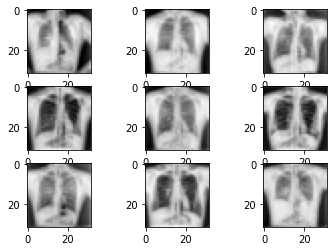

Train: X=(480, 32, 32, 1), y=(1, 480)
Test: X=(60, 32, 32, 1)


In [23]:
y_train = y_train.T #transpose y_train

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i].squeeze(), cmap='gray', vmin=0, vmax=1)
# show the figure
plt.show()

# check the shape of training data and testing data
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s' % (X_test.shape, ))

In [24]:
y_val = y_val.T

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (480, 32, 32, 1)
Shape of X_val: (120, 32, 32, 1)
Shape of y_train: (1, 480)
Shape of y_val: (1, 120)
Shape of X_test: (60, 32, 32, 1)


## 7.2 mini-batch gradient descent

In [25]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape !!!!!!!!!!!(number of examples ,input size)!!!!!!!!!!!
    Y -- true "label" vector, of shape (number of classes, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[:, permutation]
    #print("Shape of shuffled_X:", shuffled_X.shape)
    #print("Shape of shuffled_Y:", shuffled_Y.shape)
    
    inc = mini_batch_size

    # Step 2 - Partition (shuffled_X, shuffled_Y).
    # Cases with a complete mini batch size only i.e each of 64 examples.
    num_complete_minibatches = math.floor(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # For handling the end case (last mini-batch < mini_batch_size i.e less than 64)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:, :]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    
    return mini_batches

## 7.3 Start training

epoch:  0
Cost after iteration 0: 0.704476
epoch:  1
Cost after iteration 1: 0.689875
epoch:  2
Cost after iteration 2: 0.672959
epoch:  3
Cost after iteration 3: 0.644906
epoch:  4
Cost after iteration 4: 0.656956
epoch:  5
Cost after iteration 5: 0.651830
epoch:  6
Cost after iteration 6: 0.647264
epoch:  7
Cost after iteration 7: 0.659603
epoch:  8
Cost after iteration 8: 0.638598
epoch:  9
Cost after iteration 9: 0.641995
epoch:  10
Cost after iteration 10: 0.608200
epoch:  11
Cost after iteration 11: 0.624949
epoch:  12
Cost after iteration 12: 0.616859
epoch:  13
Cost after iteration 13: 0.608128
epoch:  14
Cost after iteration 14: 0.634578
epoch:  15
Cost after iteration 15: 0.584028
epoch:  16
Cost after iteration 16: 0.586620
epoch:  17
Cost after iteration 17: 0.578735
epoch:  18
Cost after iteration 18: 0.554827
epoch:  19
Cost after iteration 19: 0.584023


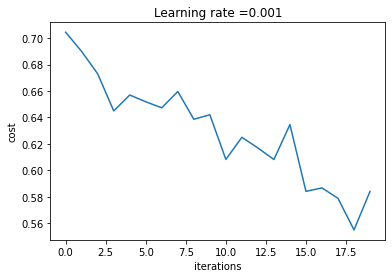

In [26]:
learning_rate = 0.001
num_iterations = 20
batch_size = 128
print_cost = True
classes = 2
costs = []   # keep track of cost


# build the model
model=Model()

model.add(Conv(filter_size=2, input_channel=1, output_channel=16, pad=0, stride=2))
model.add(Activation("relu"))
model.add(MaxPool(filter_size=2, stride=2))
model.add(Conv(filter_size=4, input_channel=16, output_channel=16, pad=0, stride=2))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Dense(144, 32))
model.add(Activation("relu"))
model.add(Dense(32, 1))
model.add(Activation("sigmoid"))


# Loop (gradient descent)
for i in range(0, num_iterations):
    print("epoch: ",i)
    mini_batches = random_mini_batches(X_train, y_train, batch_size)
    j=0
    for batch in mini_batches:
        x_batch, y_batch = batch

        # forward
        AL = model.forward(x_batch)

        # compute cost
        cost = compute_BCE_cost(AL, y_batch)

        # backward
        dA_prev = model.backward(AL, y_batch)

        # update
        model.update(learning_rate)
    
    print ("Cost after iteration %i: %f" %(i, cost))
    costs.append(cost)
            
# plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(learning_rate))
plt.show()

In [27]:
pred_train = predict(X_train, y_train, model, 2)
pred_val = predict(X_val, y_val, model, 2)

Accuracy: 0.7395833333333333
Accuracy: 0.7333333333333333


In [28]:
pred_test = predict(X_test, None, model, 2)

# 8. Advanced implementation
In this part, we will practice how to build a model by **Tensorflow**, and we finally can use GPU to accelerate the training process.

We will implement a binary classifier by Tensorflow.

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [30]:
### Data preprocess & augmentation ###

y_train = y_train.T; y_val = y_val.T

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
### Start training ###

model = models.Sequential()

model.add(data_augmentation)

model.add(layers.Conv2D(8, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
15/15 [==============================] - 3s 55ms/step - loss: 0.6937 - accuracy: 0.5063 - val_loss: 0.6904 - val_accuracy: 0.6583
Epoch 2/20
15/15 [==============================] - 1s 36ms/step - loss: 0.6881 - accuracy: 0.5583 - val_loss: 0.6812 - val_accuracy: 0.7667
Epoch 3/20
15/15 [==============================] - 1s 35ms/step - loss: 0.6682 - accuracy: 0.6917 - val_loss: 0.6172 - val_accuracy: 0.7333
Epoch 4/20
15/15 [==============================] - 1s 37ms/step - loss: 0.5867 - accuracy: 0.7229 - val_loss: 0.5474 - val_accuracy: 0.7333
Epoch 5/20
15/15 [==============================] - 1s 36ms/step - loss: 0.6175 - accuracy: 0.6729 - val_loss: 0.7381 - val_accuracy: 0.5250
Epoch 6/20
15/15 [==============================] - 1s 35ms/step - loss: 0.5569 - accuracy: 0.7417 - val_loss: 0.5759 - val_accuracy: 0.7417
Epoch 7/20
15/15 [==============================] - 1s 36ms/step - loss: 0.5305 - accuracy: 0.7667 - val_loss: 0.7161 - val_accuracy: 0.6417
Epoch 8/20
15

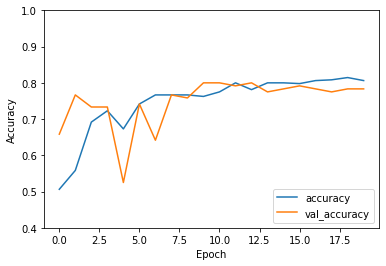

In [33]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1.0])
plt.legend(loc='lower right')

In [34]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:", train_accuracy)
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.8166666626930237
Validation Accuracy: 0.7833333611488342


In [35]:
pred_test = model.predict(X_test)
pred_test = [1 if i > 0.5 else 0 for i in pred_test]
pred_test = np.rint(pred_test)

2/2 [==============================] - 0s 13ms/step


# Linear model

In [39]:
model2 = models.Sequential()

model2.add(layers.Flatten(input_shape=(32, 32, 1)))
model2.add(layers.Dense(128, activation="relu"))
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(1, activation="sigmoid"))

model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model2.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: 0.7552 - accuracy: 0.5292 - val_loss: 0.5756 - val_accuracy: 0.7000
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 0.5645 - accuracy: 0.7417 - val_loss: 0.4827 - val_accuracy: 0.8000
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 0.4919 - accuracy: 0.7750 - val_loss: 0.4576 - val_accuracy: 0.8083
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 0.4911 - accuracy: 0.7875 - val_loss: 0.4608 - val_accuracy: 0.8000
Epoch 5/20
15/15 [==============================] - 0s 5ms/step - loss: 0.4414 - accuracy: 0.8083 - val_loss: 0.4734 - val_accuracy: 0.7667
Epoch 6/20
15/15 [==============================] - 0s 6ms/step - loss: 0.4655 - accuracy: 0.7917 - val_loss: 0.4614 - val_accuracy: 0.7750
Epoch 7/20
15/15 [==============================] - 0s 5ms/step - loss: 0.4373 - accuracy: 0.8188 - val_loss: 0.4566 - val_accuracy: 0.7750
Epoch 8/20
15/15 [=

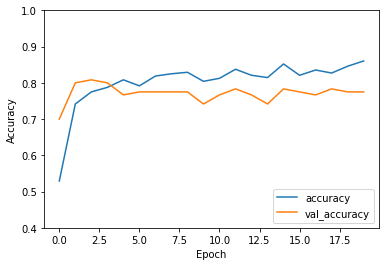

In [40]:
# Plot Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.4, 1.0])
plt.legend(loc='lower right')

In [41]:
train_loss, train_accuracy = model2.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:", train_accuracy)
val_loss, val_accuracy = model2.evaluate(X_val, y_val, verbose=0)
print("Validation Accuracy:", val_accuracy)

Training Accuracy: 0.8645833134651184
Validation Accuracy: 0.7749999761581421
